# Preprocessing gene expression from TCGA
In this notebook, I want to compute a matrix $S \in \mathbb{R}^{p \times s}$ where $s$ is the number of samples and $p$ is the number of genes. In a second step, I want to use information about the cancer type of each of the samples to aggregate the matrix to a different matrix $S_{mean} \in \mathbb{R}^{p\times c}$ where $c$ corresponds to the number of cancer types under investigation.

In [226]:
import pandas as pd
import numpy as np
import h5py, os, sys
import mygene
import matplotlib.pyplot as plt
plt.rc('font', family='Times New Roman')
import seaborn
%matplotlib inline

## Load the downloaded Data to Dataframes
I downloaded all the gene expression data from TCGA into one download directory. I now have to walk through that and load the contents to a dataframe.

Then, I join all of the dataframes together to obtain $S$.

In [104]:
def get_filenames(ge_dir):
    """Extract all valid gene expression files in dir.
    """
    all_filenames = []
    for dname in os.listdir(ge_dir):
        sub_dirname = os.path.join(ge_dir, dname)
        if os.path.isdir(sub_dirname):
            for fname in os.listdir(sub_dirname):
                if fname.endswith('.FPKM.txt.gz'):
                    all_filenames.append(os.path.join(sub_dirname, fname))
    print ("Collected {} gene expression files".format(len(all_filenames)))
    return all_filenames

names = get_filenames('../../data/pancancer/TCGA/expression/download/')

In [159]:
all_dfs = []
for fname in names:
    ge_df = pd.read_csv(fname, compression='gzip', sep='\t', header=None, names=['ID', os.path.basename(fname)])
    ge_df.set_index('ID', inplace=True)
    all_dfs.append(ge_df)

Collected 5946 gene expression files


In [172]:
sample_matrix = pd.concat(all_dfs, axis=1)
sample_matrix.shape

(60483, 5946)

In [225]:
#sample_matrix.to_csv('../../data/pancancer/TCGA/expression/sample_matrix_geneexpression.tsv', sep='\t')

## Derive Cancer Types using json file with meta information
I donwloaded a json file containing some information about all the files that were downloaded before. This can now be used to infer the cancer type of each of the samples.

Using that mapping information, I can construct the matrix $S_{mean}$ and save it to disk.

In [176]:
fname_2_ctype = pd.read_json('../../data/pancancer/TCGA/expression/meta_tcga_data/files.2018-07-23.json')

# extract cancer type and put it as extra column
ctypes = [dict(i)['project']['project_id'].split('-')[1].strip() for i in fname_2_ctype.cases.str[0]]
fname_2_ctype['cancertype'] = ctypes

# remove everything else
fname_2_ctype = fname_2_ctype[['file_name', 'cancertype']]
fname_2_ctype.set_index('file_name', inplace=True)

In [179]:
samples_with_ctype = sample_matrix.T.join(fname_2_ctype)

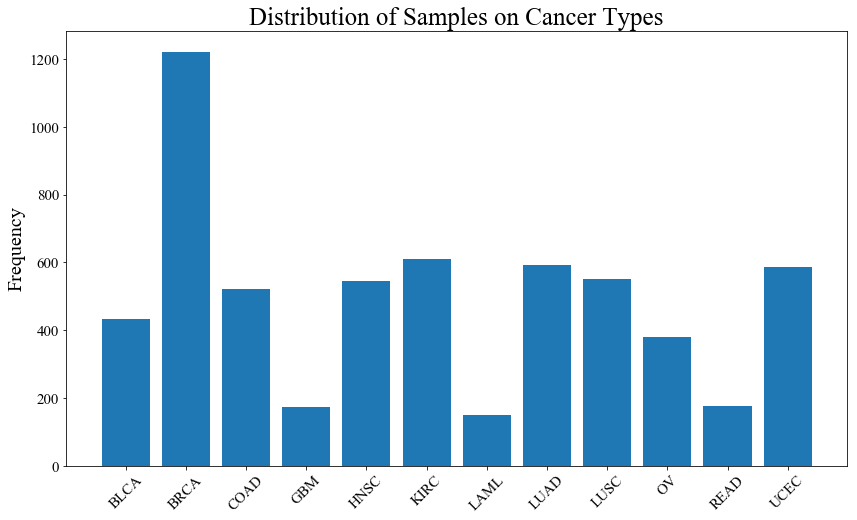

In [184]:
unique, counts = np.unique(samples_with_ctype.cancertype, return_counts=True)
fig = plt.figure(figsize=(14, 8))
ax = plt.bar(np.arange(counts.shape[0]), counts)
plt.xticks(np.arange(counts.shape[0]), unique, rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.title('Distribution of Samples on Cancer Types', fontsize=25)
fig.savefig('../../data/pancancer/TCGA/expression//samples_per_cancertype.svg')

In [186]:
mean_matrix = samples_with_ctype.fillna(0).groupby('cancertype').mean().T

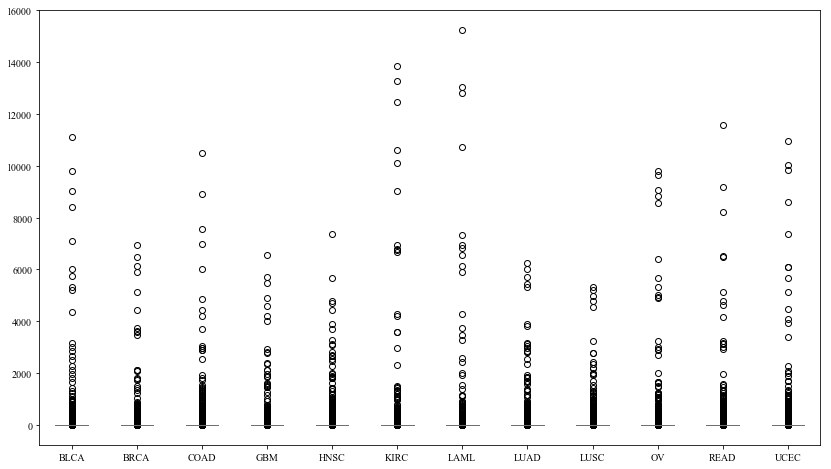

In [214]:
mean_matrix.plot(kind='box', figsize=(14, 8))
#plt.gca().set_ylim([-1, 50])

## Filter out genes that have unrealistically high gene expression
To get rid of this strange behaviour in the boxplot, it might be a good idea to kick out genes that have unrealistic gene expression.

(59534, 12)


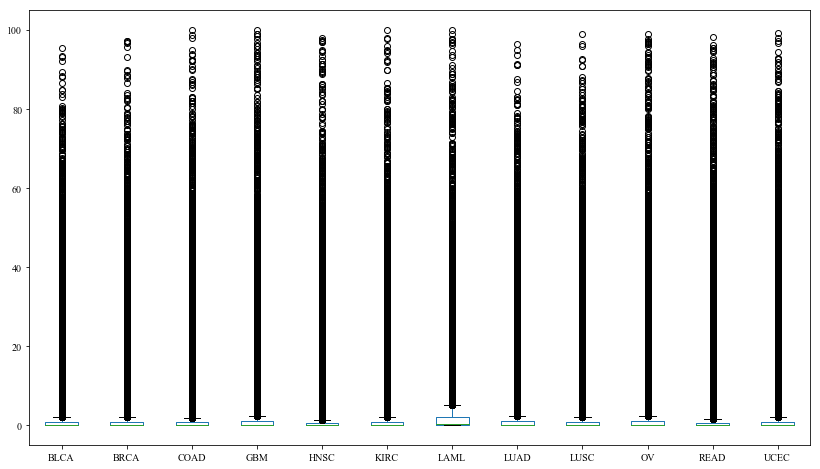

In [223]:
mean_matrix_filtered = mean_matrix[mean_matrix.max(axis=1) < 100]
print (mean_matrix_filtered.shape)
mean_matrix_filtered.plot(kind='box', figsize=(14, 8))

In [224]:
mean_matrix_filtered.to_csv('../../data/pancancer/TCGA/expression/mean_matrix_filtered.tsv', sep='\t')

## Get Gene Names for Ensembl IDs
Lastly, I want to only look at a relatively small subset of the genes. I can get the gene names for all of the Ensembl IDs and then merge those that correspond to the same one (isoforms and alternative transcripts) since I don't have that kind of resolution in my network anyways.

In [250]:
mean_matrix_filtered['ID'] = [i[0] for i in mean_matrix_filtered.index.str.split('.')]
mean_matrix_filtered.head()

/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


cancertype,BLCA,BRCA,COAD,GBM,HNSC,KIRC,LAML,LUAD,LUSC,OV,READ,UCEC,ID
ENSG00000242268.2,0.149123,0.047097,0.008670,0.597972,0.012325,0.166407,0.599515,0.083043,0.099717,0.056351,0.005553,0.127874,ENSG00000242268
ENSG00000270112.3,0.007568,0.009918,0.006132,0.153120,0.005317,0.064885,0.041206,0.009427,0.005780,0.034258,0.001003,0.020935,ENSG00000270112
ENSG00000167578.15,5.248261,3.429265,2.938618,5.464037,2.737188,2.797753,4.909341,3.986043,4.238057,4.341607,3.153047,4.963107,ENSG00000167578
ENSG00000273842.1,0.006656,0.003800,0.005778,0.003541,0.006866,0.006720,0.006839,0.001162,0.001294,0.008745,0.003568,0.021848,ENSG00000273842
ENSG00000078237.5,4.687603,3.606901,6.211797,7.261140,5.814465,3.359817,3.225872,4.526253,5.499748,3.870844,5.712283,3.377620,ENSG00000078237


In [253]:
# get gene names for Ensembl gene IDs
mg = mygene.MyGeneInfo()
res = mg.querymany([i[0] for i in mean_matrix_filtered.index.str.split('.')],
                   scopes='ensembl.gene',
                   fields='symbol',
                   species='human',
                   returnall=True
                  )

# retrieve stuff from query results and put in a DF
def get_name_and_id(x):
    name = x['symbol']
    ens_id = x['query']
    return [ens_id, name]

mapping = [get_name_and_id(x) for x in res['out'] if 'symbol' in x]
ens_2_symbol = pd.DataFrame(mapping, columns=['ID', 'Name'])
ens_2_symbol.set_index('ID', inplace=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

In [256]:
# next, look how many genes will get symbols
no_matches = mean_matrix_filtered[mean_matrix_filtered.ID.isin(ens_2_symbol.index)].shape[0]
print ("Found symbols for {} of {} genes".format(no_matches, mean_matrix_filtered.shape[0]))

Found symbols for 55929 of 59534 genes


In [287]:
# now, join the two and remove gene when it does not fit
mean_matrix_symbol = mean_matrix_filtered.join(ens_2_symbol, on='ID')
mean_matrix_symbol.dropna(axis=0, inplace=True)

# merge genes with the same name
mean_matrix_final = mean_matrix_symbol.drop('ID').groupby('Name').mean()

# add IDs again (column was lost during grouping)
mean_matrix_final = ens_2_symbol.join(mean_matrix_final, on='Name')

# write to file
mean_matrix_final.to_csv('../../data/pancancer/TCGA/expression/mean_matrix_names.tsv', sep='\t')

## Remove Genes that are not in Network

In [288]:
with h5py.File('../../data/pancancer/hotnet_iref_vec_input_unbalanced.h5', 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

In [295]:
mean_matrix_final[mean_matrix_final.Name.isin(node_names[:, 1])].shape, node_names.shape

((10732, 13), (12129, 2))

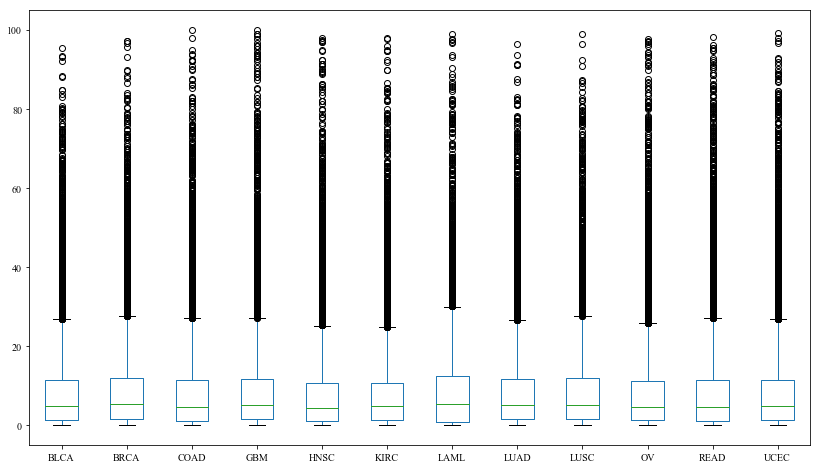

In [296]:
features_ge = mean_matrix_final[mean_matrix_final.Name.isin(node_names[:, 1])]

## Write Back to Disk
Last but not least, I write the gene expression back as features to disk. I can then use the container for multi-omics training but also train on the container only.

In [337]:
# first, bring node names to DF
nodes_df = pd.DataFrame(node_names, columns=['ensembl_id', 'name'])
nodes_df.set_index('name', inplace=True)

# add gene body and promoter information
F = nodes_df.join(features_ge.set_index('Name'))

num_of_zero_nodes = F.isnull().any(axis=1).sum()
print ("{} out of {} nodes don't have any features assigned".format(num_of_zero_nodes, network.shape[0]))
print ("--> left with valid scores for {} genes".format(network.shape[0]-num_of_zero_nodes))

# put 0 for missing data and remove name columns
F.fillna(0, inplace=True)
F.drop('ensembl_id', axis=1, inplace=True)
F = F[~F.index.duplicated()]

1417 out of 12129 nodes don't have any features assigned
--> left with valid scores for 10712 genes


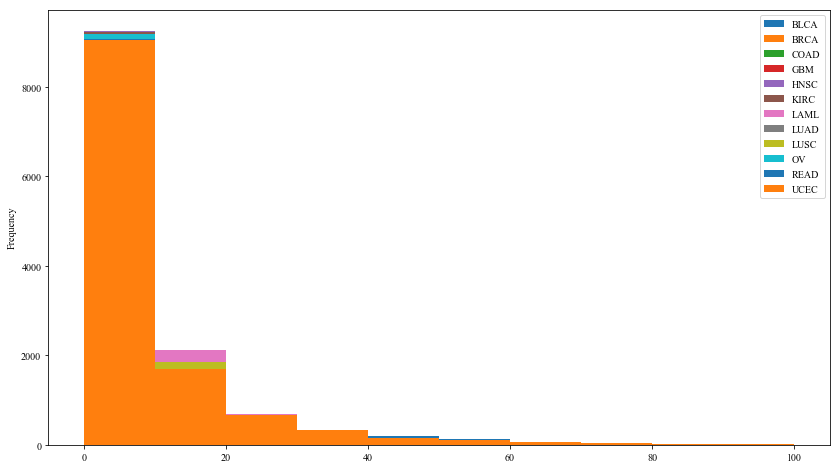

In [340]:
F.plot(kind='hist', figsize=(14, 8))

In [341]:
features = F.as_matrix()
string_dt = h5py.special_dtype(vlen=str)

fname = '../../data/pancancer/iref_tcga_expression_filter100.h5'
f = h5py.File(fname, 'w')

# add ppi network
f.create_dataset('network', data=network, shape=network.shape)

# add features
f.create_dataset('features', data=F, shape=F.shape)

# add gene names (same order as features & network)
f.create_dataset('gene_names', data=node_names, dtype=string_dt)
# add labels
f.create_dataset('y_train', data=y_train, shape=y_train.shape)
f.create_dataset('y_test', data=y_test, shape=y_test.shape)
if y_val is not None:
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)

f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
if y_val is not None:
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
f.close()
print ("Container written to {}".format(fname))

Container written to ../../data/pancancer/iref_tcga_expression_filter100.h5
